RollNumber: 2022-10-0001

# Generative Adversarial Networks
In this assignment, you’ll get hands-on experience coding and training GANs. This assignment is
divided into two parts: in the first part, we will implement a specific type of GAN designed to
process images, called a Deep Convolutional GAN (DCGAN). We’ll train the DCGAN to generate
emojis from samples of random noise. In the second part, we will apply some methods that researchers have suggested to "stablize" the training process of GANs and then train our DCGAN again.

**Note:** Please attempt this assignment on Google Colab, since that will speed up the training process.

In [3]:
import numpy as np
import os
from glob import glob
from skimage.io import imread,imshow,imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import math
from torchsummary import summary
import random
from __future__ import print_function
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torchvision
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import torch.optim as optim

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
BATCH_SIZE = 128
IMAGE_SHAPE = (64, 64)
CHANNELS = 3
NOISE_DIM = 100
EPOCHS = 500

# Use this to prefix all your paths when reading/writing data to drive.
BASE_DIR =  '/content/drive/MyDrive/Deep Learning/A4/'

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

###Load the dataset

In [31]:
transform = transforms.ToTensor()

class EmojiData(Dataset):
    def __init__(self, img_dir, transform=None): # add additional parameters needed to load the dataset e.g dataset path
        # your code here.
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        # your code here
        return len(self.img_dir)


    def __getitem__(self, idx):
        # your code here
        img_path = self.img_dir[idx]
        img = train_images = cv2.resize(remove_transparency(cv2.imread(img_path,-1),255),tuple(IMAGE_SHAPE))
        if self.transform:
            img = self.transform(img)
        return img # the output image is the label

In [32]:
###You can either use the dataloader or load all of the data using one of the helper functions
base_dir = BASE_DIR + 'filtered_emojis/*'
train_files = glob(base_dir)
training_data = EmojiData(train_files, transform)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

torch.Size([128, 3, 64, 64])


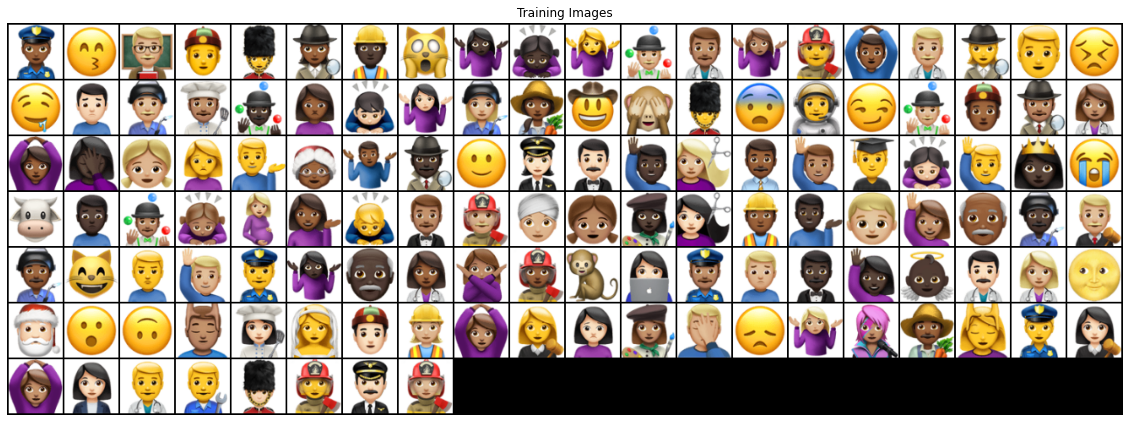

In [33]:
# Plot some training images
real_batch = next(iter(dataloader))
print(real_batch.shape)
plt.figure(figsize=(20,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch, nrow = 20, padding=2, normalize=True).cpu(),(1,2,0)))

- Here's the link to the emojis dataset: https://drive.google.com/open?id=1WRpE9SwSqguyGrrI9EP6jlHk7f1hoJMo

- Here's the link to the full emojis dataset: https://drive.google.com/open?id=1UeIQIbixvapM-TBzngOwDXnHV_vv-MBG

## PART 1: Deep Convolutional GAN (DCGAN)
For the first part of this assignment, we will implement a Deep Convolutional GAN (DCGAN).
A DCGAN is simply a GAN that uses a convolutional neural network as the discriminator, and
a network composed of transposed convolutions as the generator. To implement the DCGAN, we
need to specify three things: 1) the generator, 2) the discriminator, and 3) the training procedure.
We will develop each of these three components in the following subsections.

In [58]:
## Helper Functions
## It is upto you if you want to use them or not
def sample_noise():
    return np.reshape(np.random.randn(NOISE_DIM * BATCH_SIZE),(BATCH_SIZE,NOISE_DIM))

def remove_transparency(source, background_color):
    source_img = source[:, :, :3]
    source_mask = source[:, :, 3]  * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)
    background_mask = 1.0 - source_mask
    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)
    return cv2.cvtColor(np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0)),cv2.COLOR_BGR2RGB)

def load_data():
    base_dir = BASE_DIR + 'filtered_emojis/*'
    train_files = glob(base_dir)
    # print(train_files)
    train_images = np.array([cv2.resize(remove_transparency(cv2.imread(f,-1),255),tuple(IMAGE_SHAPE)) for f in train_files])
    return train_images

def create_image_grid(array, ncols=None):
    num_images, cell_h, cell_w, channels = array.shape
    if not ncols:
        ncols = int(np.sqrt(num_images))
    nrows = int(np.math.floor(num_images / float(ncols)))
    result = np.zeros((cell_h*nrows, cell_w*ncols, channels), dtype=array.dtype)
    for i in range(0, nrows):
        for j in range(0, ncols):
            result[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w, :] = array[i*ncols+j]

    if channels == 1:
        result = result.squeeze()
    return result

In [4]:
device = torch.device("cuda")
print("Connected to:", device)

Connected to: cuda


### Implementing the Discriminator of the DCGAN
The architecture of the discriminator is provided in an image with this notebook. You can use that or use a different one.

**Some Important points**:
- Pass in the following arguments in your Convolutional Layers: use_bias = False
- Use LeakyRelu and BatchNormalization after each convolution

Implement the discriminator in the cell below:

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [37]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [38]:
#print summary
summary(netD,input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

### Implementing the Generator of DCGAN
Now, we will implement the generator of the DCGAN, which consists of a sequence of transpose
convolutional layers that progressively upsample the input noise sample to generate a fake image.
The generator's architecture has been provided as well.
<br>

**Some important points:**
- Pass in use_bias=False, padding='same' in your convolutional layers.
- All intermediate convolutional layers will have relu activation except the last one, which will have tanh.
- All other properties can be inferred from the diagram.

Implement the generator in the cell below

In [39]:
# Generator Code
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [40]:
#initialize and cast to device
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [41]:
#print summary
summary(netG,input_size=(100,64,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 512, 67, 6]         819,200
       BatchNorm2d-2           [-1, 512, 67, 6]           1,024
              ReLU-3           [-1, 512, 67, 6]               0
   ConvTranspose2d-4         [-1, 256, 134, 12]       2,097,152
       BatchNorm2d-5         [-1, 256, 134, 12]             512
              ReLU-6         [-1, 256, 134, 12]               0
   ConvTranspose2d-7         [-1, 128, 268, 24]         524,288
       BatchNorm2d-8         [-1, 128, 268, 24]             256
              ReLU-9         [-1, 128, 268, 24]               0
  ConvTranspose2d-10          [-1, 64, 536, 48]         131,072
      BatchNorm2d-11          [-1, 64, 536, 48]             128
             ReLU-12          [-1, 64, 536, 48]               0
  ConvTranspose2d-13          [-1, 3, 1072, 96]           3,072
             Tanh-14          [-1, 3, 1

### DCGAN Training Loop
Next, you will implement the training loop for the DCGAN. A DCGAN is simply a GAN with a
specific type of generator and discriminator; thus, we train it in exactly the same way as a standard
GAN. The pseudo-code for the training procedure is shown below.

**Algorithm:**    
1. Draw m training examples {x<sup>(1)</sup>,...,x<sup>(m)</sup>} from the data distribution p<sub>data</sub>.
2. Draw m noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
3. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
4. Compute discriminator's loss on real images and fake images batches and then update the parameters.
5. Draw m NEW noise samples {z<sup>(1)</sup>,...,z<sup>(m)</sup>} from the noise distribution p<sub>z</sub>.    
6. Generate fake images from the noise: G(z<sup>(i)</sup>) for i in {1,....,m}.    
7. Freeze the discriminator.
8. Compute generator's loss then update the parameters.
9. Unfreeze the discriminator.

Before we move to writing the training loop, we will need to create a "combined" model that will attach the discriminator over the generator. This model will be used to train the generator as the discriminator will act as an adversary for the generator and force it to generate realistic images.

In this function below you need to create a model that:
- Takes noise z as input (Matching the noise dimensions defined at the top of the notebook)
- Gets a fake image generated from the generator using this noise z
- "Freezes" the discriminator (Setting all layers of the discriminator as untrainable)
- Outputs the output of the discriminator based on the input z.

Remember to compile the model before returning it.

In [42]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
lr = 0.0002
beta1 = 0.5

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Training the GAN
We will train a DCGAN to generate fake Apple emojis.

Write your training loop in the cell bellow.

In [44]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/6]	Loss_D: 1.7884	Loss_G: 5.4036	D(x): 0.9994	D(G(z)): 0.7760 / 0.0077
[1/500][0/6]	Loss_D: 0.1214	Loss_G: 7.7682	D(x): 0.9779	D(G(z)): 0.0829 / 0.0007
[2/500][0/6]	Loss_D: 0.1163	Loss_G: 9.2961	D(x): 0.9751	D(G(z)): 0.0831 / 0.0001
[3/500][0/6]	Loss_D: 0.8403	Loss_G: 24.3817	D(x): 0.9971	D(G(z)): 0.5219 / 0.0000
[4/500][0/6]	Loss_D: 0.3363	Loss_G: 27.5503	D(x): 0.8295	D(G(z)): 0.0000 / 0.0000
[5/500][0/6]	Loss_D: 0.0012	Loss_G: 26.5109	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000
[6/500][0/6]	Loss_D: 0.0306	Loss_G: 13.3000	D(x): 0.9814	D(G(z)): 0.0000 / 0.0000
[7/500][0/6]	Loss_D: 3.6018	Loss_G: 22.8799	D(x): 0.9998	D(G(z)): 0.9620 / 0.0000
[8/500][0/6]	Loss_D: 0.1480	Loss_G: 15.7033	D(x): 0.9063	D(G(z)): 0.0000 / 0.0000
[9/500][0/6]	Loss_D: 2.9789	Loss_G: 22.3019	D(x): 0.9812	D(G(z)): 0.9310 / 0.0000
[10/500][0/6]	Loss_D: 0.4788	Loss_G: 12.0370	D(x): 0.7851	D(G(z)): 0.0000 / 0.0000
[11/500][0/6]	Loss_D: 1.1616	Loss_G: 14.6943	D(x): 0.9271	D(G(z)): 0.5815 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3741355290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3741355290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[419/500][0/6]	Loss_D: 0.0333	Loss_G: 5.0547	D(x): 0.9819	D(G(z)): 0.0140 / 0.0125


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3741355290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3741355290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[420/500][0/6]	Loss_D: 0.0442	Loss_G: 5.3526	D(x): 0.9885	D(G(z)): 0.0309 / 0.0076
[421/500][0/6]	Loss_D: 0.0338	Loss_G: 4.8796	D(x): 0.9786	D(G(z)): 0.0113 / 0.0110
[422/500][0/6]	Loss_D: 0.0773	Loss_G: 9.0185	D(x): 0.9329	D(G(z)): 0.0006 / 0.0017
[423/500][0/6]	Loss_D: 0.0260	Loss_G: 5.7197	D(x): 0.9926	D(G(z)): 0.0179 / 0.0063
[424/500][0/6]	Loss_D: 0.0529	Loss_G: 5.9463	D(x): 0.9880	D(G(z)): 0.0386 / 0.0038
[425/500][0/6]	Loss_D: 0.0282	Loss_G: 4.9290	D(x): 0.9938	D(G(z)): 0.0212 / 0.0109
[426/500][0/6]	Loss_D: 0.0487	Loss_G: 4.2971	D(x): 0.9642	D(G(z)): 0.0108 / 0.0226
[427/500][0/6]	Loss_D: 0.0292	Loss_G: 5.6052	D(x): 0.9911	D(G(z)): 0.0196 / 0.0060
[428/500][0/6]	Loss_D: 0.7927	Loss_G: 9.2520	D(x): 0.6476	D(G(z)): 0.0011 / 0.0976
[429/500][0/6]	Loss_D: 2.2090	Loss_G: 16.0332	D(x): 0.9849	D(G(z)): 0.7288 / 0.0000
[430/500][0/6]	Loss_D: 1.3526	Loss_G: 12.2416	D(x): 0.9987	D(G(z)): 0.6296 / 0.0001
[431/500][0/6]	Loss_D: 0.3910	Loss_G: 7.0249	D(x): 0.7771	D(G(z)): 0.0532 / 0.0117
[4

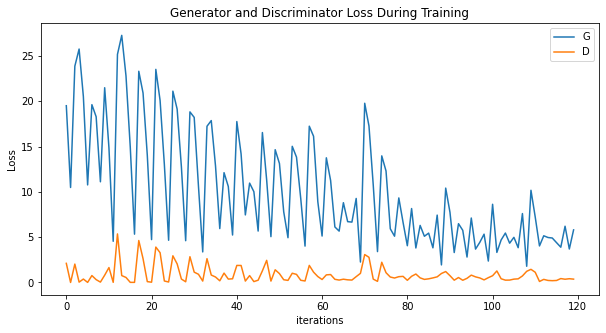

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generating Samples and Analysis

- Plot your discriminator and generator losses.
- Generate random 5 noise samples and their corresponding fake images.

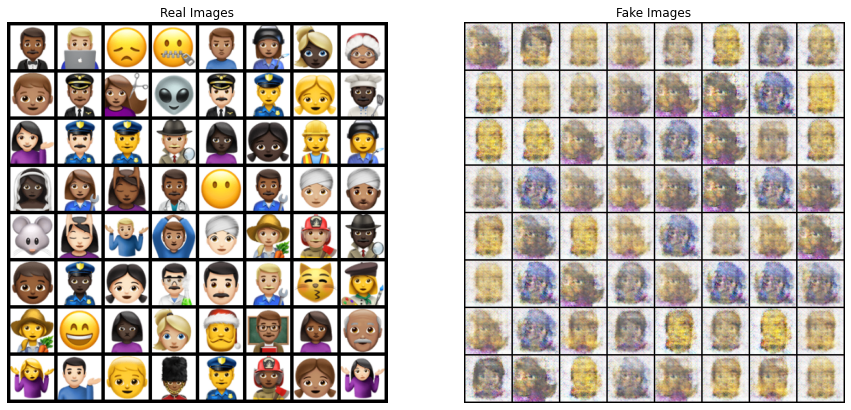

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

###Analysis

## PART 2: Stabilizing GANs

In the first part, we trained our GAN using the standard methods proposed initially. In this part we will tweak our models and our training loop based on suggestions that deep learning researchers have come up with through their experiences. We will see if we encountered into typical problems faced while training GANs and see if these proposed methods improve our GANs and resolve issuse previously faced.

We have already implemented a GAN based on the recommendations made by Alec Radford, et al. in the 2015 paper titled [“Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.”](https://arxiv.org/abs/1511.06434)



We have:
1. Downsampled using strided convolutions
2. Upsampled using strided convolutions
3. Used LeakyReLu in our discriminator, and ReLu in the generator and Tanh for the output of the generator.
4. Used BatchNormalization in both the discriminator and generator.

In addition to these, we will also make use of some more tips from the aforementioned paper, as well as tips from Soumith Chintala, who is one of the co-authors of the DCGAN paper in his [NIPS presentation](https://www.youtube.com/watch?v=X1mUN6dD8uE)

### Modifications in the Models

Here are some suggested modifications in the generator and discriminator models:

- Use LeakyReLu in BOTH the generator and discriminator
- Use Gaussian Weight initialization with mean=0 and std = 0.02. (https://pytorch.org/docs/stable/nn.init.html)
- Use Adam optimizer

Make these modifications in your generator and discriminator models.

In [24]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [25]:
# Discriminator Code
class DiscriminatorB(nn.Module):
    def __init__(self):
        super(DiscriminatorB, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [27]:
# Create the Discriminator
netD_B = DiscriminatorB().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD_B.apply(weights_init)

DiscriminatorB(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [28]:
# Create the generator
netG_B = GeneratorB().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG_B.apply(weights_init)

GeneratorB(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Scale Images to the Range [-1,1]
We already know that normalizing images improves training for any model. We will scale our images in the range [-1,1] since we are using a tanh activation in our generator. This will make the fake generated images and real images in the same range and will enable our discriminator to learn better.    
Implement the following function to normalize a numpy array containing images. **Note:** The images will be in the range [0,255]

In [19]:
def normalize(images):
    images = images - (1/255.0)
    images = images * 2.0 - 1.0
    return images

### Use Gaussian Latent Space
Previously we have been using a uniform distribution to sample a latent space as recommended in the DCGAN paper, but more recently researchers suggest to use a Standard Gaussian distribution to sample the latent space. Modify the <code>sample_noise</code> function to sample from a Gaussian distribution.

In [20]:
def sample_noise():
    mean = 1
    variance = 1
    return np.reshape(np.random.normal(mean, variance, size = (NOISE_DIM * BATCH_SIZE)) , (BATCH_SIZE,NOISE_DIM))

### Use Label Smoothing
Normally, we use hard labels 1s and 0s to train our GANs. Researchers have suggested to smooth labels and use "soft" labels . This is said to have a "regularizing" effect on the training.

#### Real Label Smoothing
For Real labels, i.e. 1s, we will smooth the labels uniformly between [0.7,1.2]. Use np.random.random for this.

In [50]:
def smooth_real_labels(y):
    return np.random.uniform(0.7, 1.2, y*1).astype(np.float32)

#### Fake Label Smoothing

In [51]:
def smooth_fake_labels(y):
    return np.random.uniform(0.0, 0.3, y*1).astype(np.float32)

We will make use of these functions later in our training loop.

###Load the dataset

In [52]:
transform = transforms.ToTensor()

class EmojiDataB(Dataset):
    def __init__(self, img_dir, transform=None): # add additional parameters needed to load the dataset e.g dataset path
        # your code here.
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        # your code here
        return len(self.img_dir)


    def __getitem__(self, idx):
        # your code here
        img_path = self.img_dir[idx]
        img = train_images = cv2.resize(remove_transparency(cv2.imread(img_path,-1),255),tuple(IMAGE_SHAPE))
        img = img*2 - 1
        if self.transform:
            img = self.transform(img)
        return img # the output image is the label

In [53]:
###You can either use the dataloader or load all of the data using one of the helper functions
base_dir = BASE_DIR + 'filtered_emojis/*'
train_files = glob(base_dir)
training_data = EmojiDataB(train_files, transform)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

### Train Discriminator with Real and Fake Images separately
Previously we were combining our fake and real images batches and doing one update to our discriminator. Researchers suggest that the best practice is to train our discriminator in two updates, one for the real images and one for the fake images.

### Flip some labels randomly while training the Generator
Soumith Chintala also suggests that in practice, ocassionally flipping the labels of the generator may help (Swapping Real and Fake)

### Modified Training Loop

Incorporate the above mentioned suggestions in your training process. You don't have to apply all of them. See which combination works best for you. Mention the methods you made use of. Plot the losses and final images just as in the previous part.

### Incorporated Modifications:
1. Replace all ReLU with LeakyReLU
2. All image tensors normalized between -1 and 1
3. Soft labels used. For 0 hard label, range -0.3 to 0.2 was set
4. Train discriminatir for real and fake images separately


In [15]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
lr = 0.0002
beta1 = 0.5

# Setup optimizers for both G and D
optimizerD = optim.Adam(netD_B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG_B.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD_B.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        # print("real_cpu", real_cpu.shape[0])
        label = torch.from_numpy(smooth_real_labels(real_cpu.shape[0]))
        label = label.to(device)
        # Forward pass real batch through D
        output = netD_B(real_cpu).view(-1)
        # Calculate loss on all-real batch
        # print('output', output.shape)
        # print('label', label.shape)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG_B(noise)
        label = torch.from_numpy(smooth_fake_labels(BATCH_SIZE))
        label = label.to(device)
        # Classify all fake batch with D
        output = netD_B(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG_B.zero_grad()
        label = torch.from_numpy(smooth_real_labels(BATCH_SIZE))
        label = label.to(device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD_B(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG_B(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/6]	Loss_D: 1.7884	Loss_G: 5.4036	D(x): 0.9994	D(G(z)): 0.7760 / 0.0077
[1/500][0/6]	Loss_D: 0.1214	Loss_G: 7.7682	D(x): 0.9779	D(G(z)): 0.0829 / 0.0007
[2/500][0/6]	Loss_D: 0.1163	Loss_G: 9.2961	D(x): 0.9751	D(G(z)): 0.0831 / 0.0001
[3/500][0/6]	Loss_D: 0.8403	Loss_G: 24.3817	D(x): 0.9971	D(G(z)): 0.5219 / 0.0000
[4/500][0/6]	Loss_D: 0.3363	Loss_G: 27.5503	D(x): 0.8295	D(G(z)): 0.0000 / 0.0000
[5/500][0/6]	Loss_D: 0.0012	Loss_G: 26.5109	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000
[6/500][0/6]	Loss_D: 0.0306	Loss_G: 13.3000	D(x): 0.9814	D(G(z)): 0.0000 / 0.0000
[7/500][0/6]	Loss_D: 3.6018	Loss_G: 22.8799	D(x): 0.9998	D(G(z)): 0.9620 / 0.0000
[8/500][0/6]	Loss_D: 0.1480	Loss_G: 15.7033	D(x): 0.9063	D(G(z)): 0.0000 / 0.0000
[9/500][0/6]	Loss_D: 2.9789	Loss_G: 22.3019	D(x): 0.9812	D(G(z)): 0.9310 / 0.0000
[10/500][0/6]	Loss_D: 0.4788	Loss_G: 12.0370	D(x): 0.7851	D(G(z)): 0.0000 / 0.0000
[11/500][0/6]	Loss_D: 1.1616	Loss_G: 14.6943	D(x): 0.9271	D(G(z)): 0.5815 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3741355290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3741355290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[419/500][0/6]	Loss_D: 0.0333	Loss_G: 5.0547	D(x): 0.9819	D(G(z)): 0.0140 / 0.0125


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3741355290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3741355290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[420/500][0/6]	Loss_D: 0.0442	Loss_G: 5.3526	D(x): 0.9885	D(G(z)): 0.0309 / 0.0076
[421/500][0/6]	Loss_D: 0.0338	Loss_G: 4.8796	D(x): 0.9786	D(G(z)): 0.0113 / 0.0110
[422/500][0/6]	Loss_D: 0.0773	Loss_G: 9.0185	D(x): 0.9329	D(G(z)): 0.0006 / 0.0017
[423/500][0/6]	Loss_D: 0.0260	Loss_G: 5.7197	D(x): 0.9926	D(G(z)): 0.0179 / 0.0063
[424/500][0/6]	Loss_D: 0.0529	Loss_G: 5.9463	D(x): 0.9880	D(G(z)): 0.0386 / 0.0038
[425/500][0/6]	Loss_D: 0.0282	Loss_G: 4.9290	D(x): 0.9938	D(G(z)): 0.0212 / 0.0109
[426/500][0/6]	Loss_D: 0.0487	Loss_G: 4.2971	D(x): 0.9642	D(G(z)): 0.0108 / 0.0226
[427/500][0/6]	Loss_D: 0.0292	Loss_G: 5.6052	D(x): 0.9911	D(G(z)): 0.0196 / 0.0060
[428/500][0/6]	Loss_D: 0.7927	Loss_G: 9.2520	D(x): 0.6476	D(G(z)): 0.0011 / 0.0976
[429/500][0/6]	Loss_D: 2.2090	Loss_G: 16.0332	D(x): 0.9849	D(G(z)): 0.7288 / 0.0000
[430/500][0/6]	Loss_D: 1.3526	Loss_G: 12.2416	D(x): 0.9987	D(G(z)): 0.6296 / 0.0001
[431/500][0/6]	Loss_D: 0.3910	Loss_G: 7.0249	D(x): 0.7771	D(G(z)): 0.0532 / 0.0117
[4

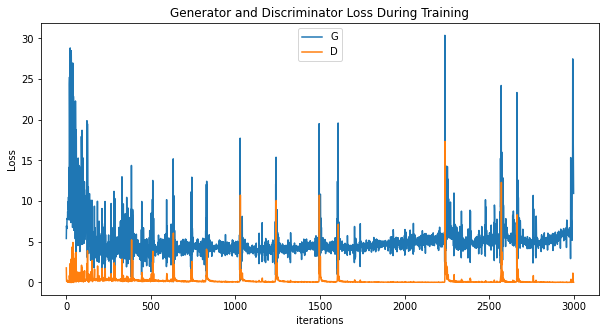

In [45]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

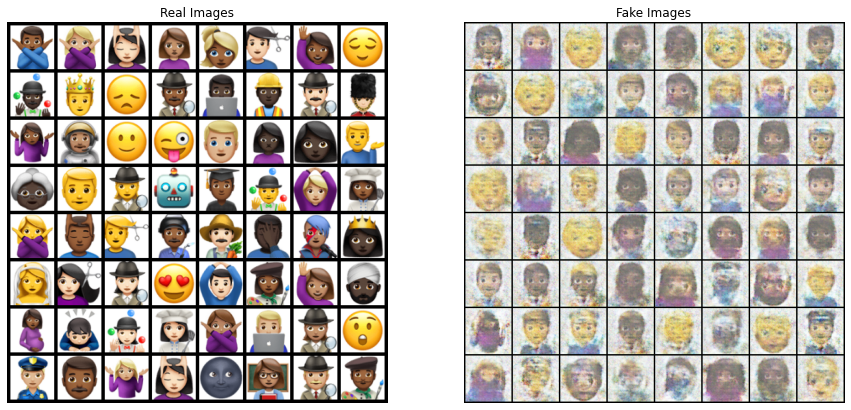

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

###Analysis

The methods which worked for you and analysis:

## PART 3: Interpolation

You have to do this part in Keras.

Model weight is provided. Dataset link: https://drive.google.com/drive/folders/1tg-Ur7d4vk1T8Bn0pPpUSQPxlPGBlGfv

In [38]:
import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Conv2D,Activation,BatchNormalization,Conv2DTranspose, Input, Flatten, Dense, Reshape, LeakyReLU, Dropout
from keras.models import Sequential, Model
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import linspace
from os import listdir

In [56]:
# replace this your google drive path of the zip file of dataset provided with this homework
!unzip -o -q "/content/drive/MyDrive/Deep Learning/A4/thumbnails128x128" -d "/content/drive/MyDrive/Deep Learning/A4/T3"

unzip:  cannot find or open /content/drive/MyDrive/Deep Learning/A4/thumbnails128x128, /content/drive/MyDrive/Deep Learning/A4/thumbnails128x128.zip or /content/drive/MyDrive/Deep Learning/A4/thumbnails128x128.ZIP.


In [5]:
# data folder path in colab runtime enviroment
DATA_FOLDER = '/content/drive/MyDrive/Deep Learning/A4/thumbnails128x128'

# fetching all the filenmaes to read them later in generator
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.png')))

# total images in directory
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 70000


In [6]:
INPUT_DIM = (128,128,3) 
BATCH_SIZE = 256      
Z_DIM = 100             

#data generator
data_flow = ...

*  Model weights are provided to you, use that model and interpolate 5 images.
*  If you want to train the model from scratch it's up to you.



In [7]:
def define_generator():
	model = Sequential()
	n_nodes = 128 * 4 * 4
	model.add(Dense(n_nodes, input_dim=Z_DIM))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

In [8]:
#initialize the model here and generate some sample images
model = define_generator()
model.load_weights('/content/drive/MyDrive/Deep Learning/A4/generator.h5')

In [9]:
def generate_latent_vector(Z_dim, num_samples):
	temp = randn(Z_dim * num_samples)
	return temp.reshape(num_samples, Z_dim)

In [24]:
def plot_images(examples, n):
  pyplot.figure(figsize=(20, 20))
  for i in range(n):
    pyplot.subplot(1 , n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i, :, :], interpolation='nearest')
  pyplot.show()

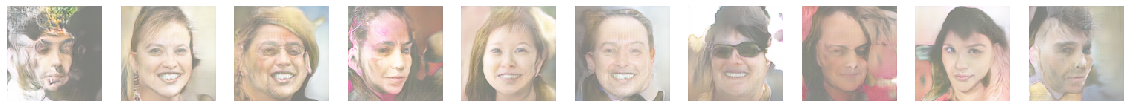

In [25]:
# generate 10 different images
pts = generate_latent_vector(100, 10)
X = model.predict(pts)
X = ( (X + 1) / 2.0 )
plot_images(X, 10)

In [26]:
def interpolate_points(img1, img2, number=10):
	ratios = linspace(0, 1, number)
	# linear interpolate vectors
	interpolated_images = []
	for ratio in ratios:
		interpolated_images.append((1.0 - ratio) * img1 + ratio * img2)
	return asarray(interpolated_images)

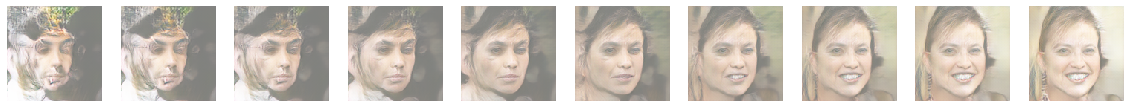

In [28]:
# interpolate images
interpolated = interpolate_points(pts[0], pts[1])
X = model.predict(interpolated)
X = (X + 1) / 2.0
plot_images(X, len(interpolated))

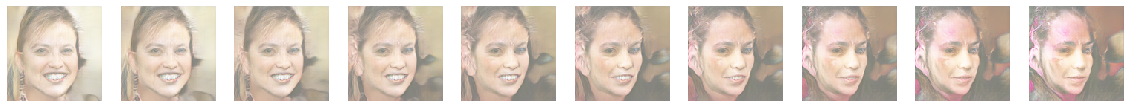

In [29]:
# interpolate images
interpolated = interpolate_points(pts[1], pts[3])
X = model.predict(interpolated)
X = (X + 1) / 2.0
plot_images(X, len(interpolated))

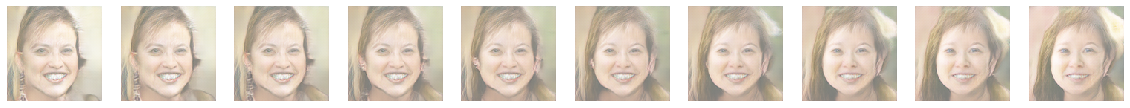

In [30]:
# interpolate images
interpolated = interpolate_points(pts[1], pts[4])
X = model.predict(interpolated)
X = (X + 1) / 2.0
plot_images(X, len(interpolated))

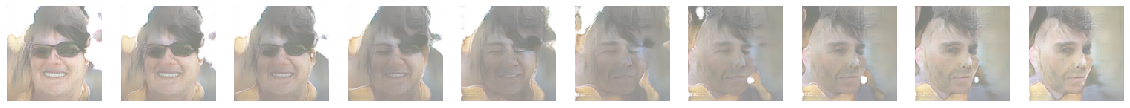

In [31]:
# interpolate images
interpolated = interpolate_points(pts[6], pts[9])
X = model.predict(interpolated)
X = (X + 1) / 2.0
plot_images(X, len(interpolated))

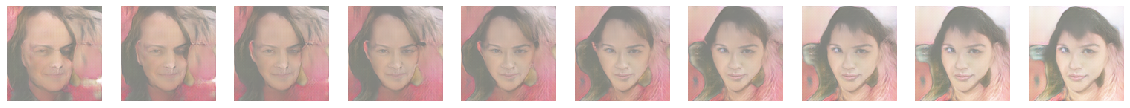

In [32]:
# interpolate images
interpolated = interpolate_points(pts[7], pts[8])
X = model.predict(interpolated)
X = (X + 1) / 2.0
plot_images(X, len(interpolated))

You can play around with the images for example:
	
1.  *Glasses on Woman - Neutral Woman + Neutral Man = Glasses on Man*
2.  *Smile on Woman - Neutral Woman + Neutral Man = smile on Man*

Create 10 different scenarios and display

In [33]:
def plot_images(examples, n):
  pyplot.figure(figsize=(20, 20))
  for i in range(n*n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i, :, :], interpolation='nearest')
  pyplot.show()

In [39]:
from PIL import Image
def load_faces(directory_list, n_faces):
  faces = []
  # enumerate files
  for img_dir in listdir(directory_list):
    image = Image.open(img_dir)
    image = image.convert('RGB')
    pixels = asarray(image)
    faces.append(pixels)
    # stop once we have enough
    if len(faces) >= n_faces:
      break
    return asarray(faces)

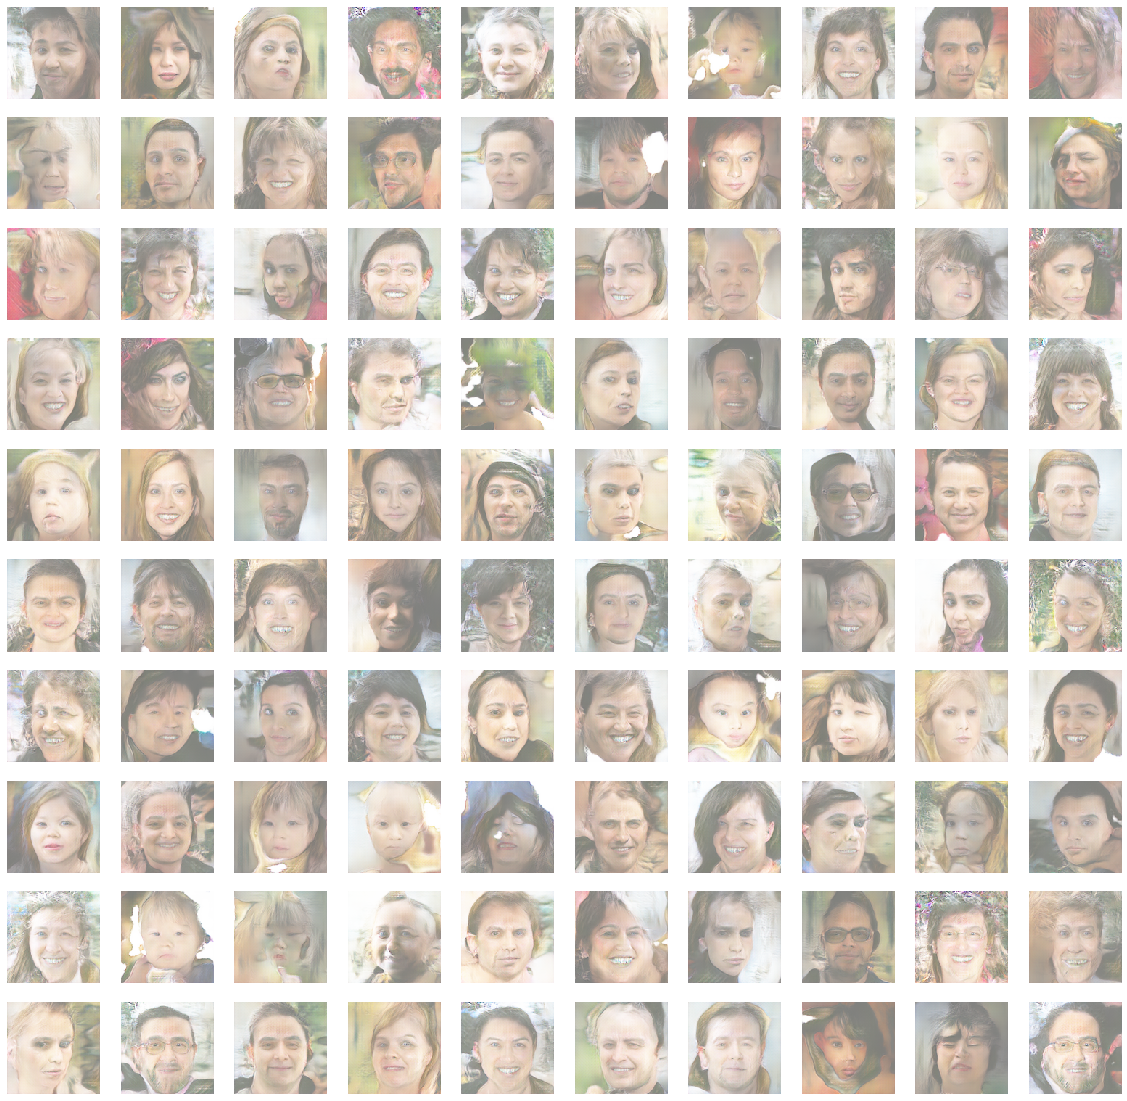

In [34]:
# generate sample of 100 random images

pts = generate_latent_vector(100, 100)
X = model.predict(pts)
X = ( (X + 1) / 2.0 )
plot_images(X, 10)

#### Display Results

In [46]:
from numpy import mean
from numpy import vstack
def average_points(points, ix):
	zero_ix = [i-1 for i in ix]
	vectors = points[zero_ix]
	avg_vector = mean(vectors, axis=0)
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

def plot_new(examples, rows, cols):
  pyplot.figure(figsize=(10, 10))
  for i in range(rows * cols):
    pyplot.subplot(rows, cols, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i, :, :], interpolation='nearest')
    
  pyplot.show()

(12, 100)


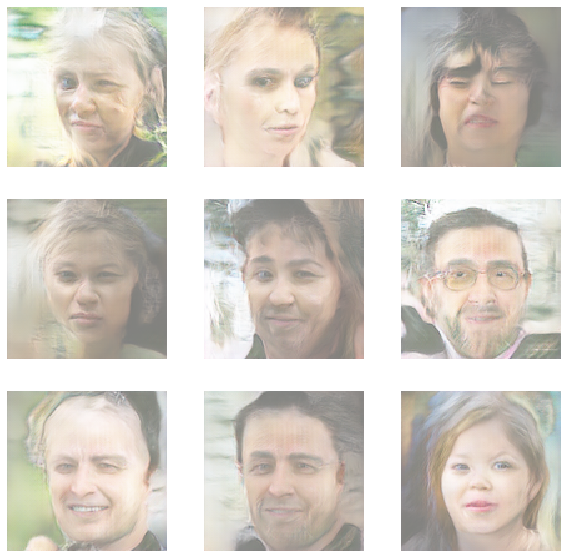

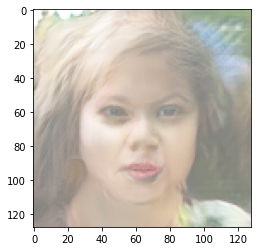

In [59]:
from numpy import expand_dims

# case 1: glasses on man - neutral man + neutral women = glasses on women
glasses_man_index = [47, 91, 99]
neutral_man_index = [1, 92, 96]
neutral_woman_index = [71, 90, 93]

# average vectors
glasses_man = average_points(pts, glasses_man_index)
neutral_man = average_points(pts, neutral_man_index)
neutral_women = average_points(pts, neutral_woman_index)
# combine all vectors
all_vectors = vstack((glasses_man, neutral_man, neutral_women))
print(all_vectors.shape)
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_new(images, 3, 3)

# smiling woman - neutral woman + neutral man = smiling man
result_vector = glasses_man[-1] - neutral_man[-1] + neutral_women[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

(12, 100)


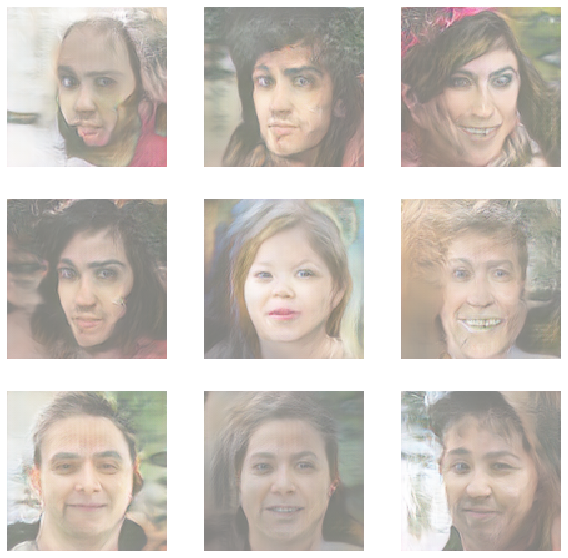

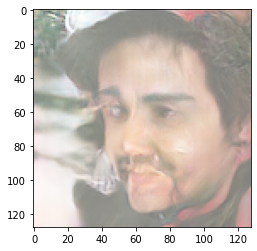

In [60]:
# case 2: glasses on woman - neutral woman + neutral man = glasses on man
glasses_woman_index = [23, 28, 32]
neutral_man_index = [1, 92, 96]
neutral_woman_index = [71, 90, 93]

# average vectors
glasses_woman = average_points(pts, glasses_woman_index)
neutral_man = average_points(pts, neutral_man_index)
neutral_women = average_points(pts, neutral_woman_index)
# combine all vectors
all_vectors = vstack((glasses_woman, neutral_women, neutral_man))
print(all_vectors.shape)
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_new(images, 3, 3)

result_vector = glasses_woman[-1] - neutral_women[-1] + neutral_man[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

(11, 100)


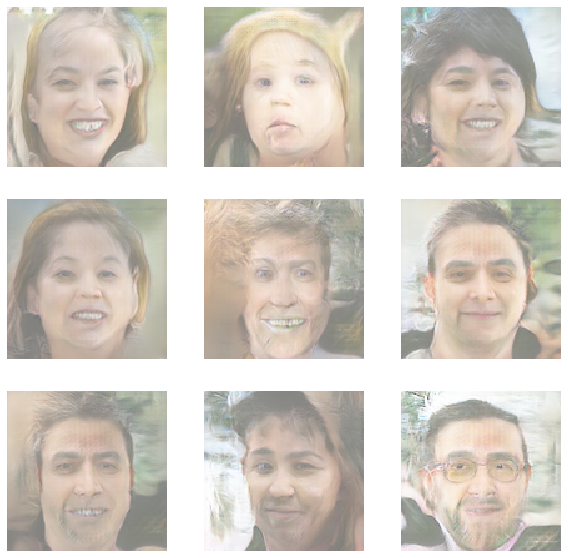

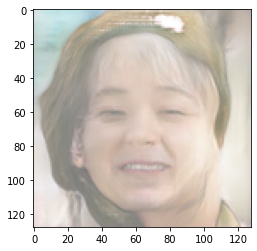

In [52]:
# case 3: smiling woman - neutral woman + neutral man = smiling man
smiling_woman_index = [31, 41, 64]
neutral_man_index = [1, 92, 96]
neutral_woman_index = [71, 90, 93]

# average vectors
smiling_woman = average_points(pts, smiling_woman_index)
neutral_man = average_points(pts, neutral_man_index)
neutral_woman = average_points(pts, neutral_woman_index)
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_women, neutral_man))
print(all_vectors.shape)
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_new(images, 3, 3)

result_vector = smiling_woman[-1] - neutral_women[-1] + neutral_man[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()

(11, 100)


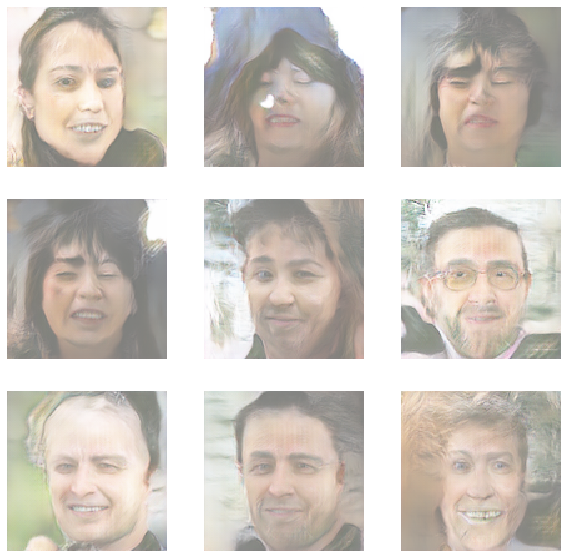

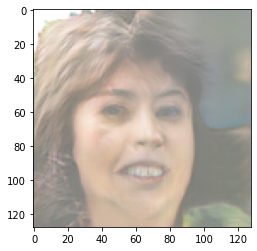

In [57]:
# case 4: smiling woman - neutral woman + neutral man = smiling man
smiling_man_index = [65, 75, 99]
neutral_man_index = [1, 92, 96]
neutral_woman_index = [71, 90, 93]

# average vectors
smiling_man = average_points(pts, smiling_man_index)
neutral_man = average_points(pts, neutral_man_index)
neutral_woman = average_points(pts, neutral_woman_index)
# combine all vectors
all_vectors = vstack((smiling_man, neutral_man, neutral_women))
print(all_vectors.shape)
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_new(images, 3, 3)

result_vector = smiling_man[-1] - neutral_man[-1] + neutral_women[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()